<a href="https://colab.research.google.com/github/xxxnmxhj00/Deep-Learning/blob/main/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import urllib3
import zipfile
import shutil
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import text

In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip


--2024-09-03 05:03:36--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip.5’

fra-eng.zip.5       100%[===================>]   7.57M  6.42MB/s    in 1.2s    

2024-09-03 05:03:38 (6.42 MB/s) - ‘fra-eng.zip.5’ saved [7943074/7943074]



In [ ]:
filename = 'fra-eng.zip'
path = os.getcwd()                                      # os.getcwd() 함수는 현재 작업 디렉토리의 경로를 반환
zipfilename = os.path.join(path, filename)              # os.path.join() 함수는 path와 filename을 결합하여 ZIP 파일의 전체 경로를 생성

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:      # zipfile.ZipFile() 클래스는 ZIP 파일을 읽거나 쓰기 위한 객체를 생성
    zip_ref.extractall(path)                            # extractall() 메서드는 ZIP 파일의 모든 파일을 지정된 디렉토리에 추출

In [ ]:
lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']
print('전체 샘플의 개수 :',len(lines))

전체 샘플의 개수 : 232736


In [ ]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:45000]
lines.sample(10) # sample() 메서드는 데이터프레임에서 무작위 샘플을 추출

,src,tar
37559,Tom's door is open.,La porte de Tomas est ouverte.
10196,You look lost.,Vous avez l'air perdu.
5897,It's a waste.,Il s'agit d'un gaspillage.
43934,The fridge is empty.,Le frigo est vide.
16943,Meet me at 2:30.,Rendez-vous à 14 h 30.
26495,I appreciate this.,Je l'apprécie.
36024,She threatened him.,Elle le menaça.
7624,His nose bled.,Il saignait du nez.
32929,He gave her a book.,Il lui a donné un livre.
8396,I'm from here.,Je suis d'ici.


In [ ]:
lines.tar = lines.tar.apply(lambda x : '\t ' + x + ' \n') # 데이터프레임 lines의 'tar' 열을 참조
lines.sample(10) # 'tar' 열의 각 항목은 탭과 공백으로 시작하고, 공백과 줄 바꿈 문자로 끝나는 문자열로 변환됩니다.

,src,tar
16225,I'm introverted.,\t Je suis introvertie. \n
25652,Did you read them?,\t Les as-tu lus ? \n
25651,Did you phone Tom?,\t Tu as appelé Tom ? \n
1443,Nice shot!,\t Joli coup ! \n
14478,Call the police!,\t Appelle la police! \n
6811,We're losing.,\t Nous perdons. \n
17850,Tom has friends.,\t Tom a des amis. \n
12391,Leave me alone!,\t Laisse-moi seule ! \n
6203,Stay outside.,\t Reste à l'extérieur. \n
24862,You looked at me.,\t Tu m'as regardé. \n


In [ ]:
# 글자 집합 구축
src_vocab = set() # src_vocab이라는 빈 집합을 생성
for line in lines.src:
    for char in line:
      src_vocab.add(char) # src_vocab 집합에는 'src' 열에서 발견된 모든 고유 문자가 저장

tar_vocab = set()
for line in lines.tar:    # lines 데이터프레임의 'tar' 열의 각 행을 반복
    for char in line:    # 각 행에서 발견된 문자를 반복
      tar_vocab.add(char)

      #'src' 열의 모든 문자열에서 사용된 고유 문자를 src_vocab 집합에 저장합니다.
      #'tar' 열의 모든 문자열에서 사용된 고유 문자를 tar_vocab 집합에 저장합니다.

In [ ]:
src_vocab_size = len(src_vocab) + 1
tar_vocab_size = len(tar_vocab) + 1
print('source 문장의 char 집합 :', src_vocab_size)
print('target 문장의 char 집합 :', tar_vocab_size)

source 문장의 char 집합 : 78
target 문장의 char 집합 : 102


In [ ]:
src_vocab = sorted(list(src_vocab)) # src_vocab 집합을 리스트로 변환, 리스트를 정렬
tar_vocab = sorted(list(tar_vocab))
print(src_vocab[45:75])
print(tar_vocab[45:75])

['W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
# enumerate(src_vocab): src_vocab 리스트의 각 문자와 해당 인덱스를 함께 반환합니다. enumerate() 함수는 (인덱스, 문자) 쌍을 생성합니다.
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

# [(word, i+1) for i, word in enumerate(src_vocab)]: 리스트 컴프리헨션을 사용하여 (문자, 인덱스+1) 쌍을 생성합니다. i+1을 사용하는 이유는
# 일반적으로 인덱스는 0부터 시작하지만, 많은 경우 인덱스를 1부터 시작하고 0은 패딩이나 다른 목적으로 예약하는 경우가 많습니다.

# src_vocab과 tar_vocab의 각 문자(또는 단어)에 대해 인덱스를 매기고, 이 매핑 정보를 딕셔너리 형태로 저장

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, 'ï': 77}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, ',': 10, '-': 11, '.': 12, '0': 13, '1': 14, '2': 15, '3': 16, '4': 17, '5': 18, '6': 19, '7': 20, '8': 21, '9': 22, ':': 23, '?': 24, 'A': 25, 'B': 26, 'C': 27, 'D': 28, 'E': 29, 'F': 30, 'G': 31, 'H': 32, 'I': 33, 'J': 34, 'K': 35, 'L': 3

In [ ]:
encoder_input = []

# 1개의 문장
for line in lines.src:                              # lines 데이터프레임의 'src' 열에 있는 각 문장(문자열)을 반복합니다
  encoded_line = []
  # 각 줄에서 1개의 char
  for char in line:                                 # 현재 문장(line)에서 각 문자를 반복
    # 각 char을 정수로 변환
    encoded_line.append(src_to_index[char])         # src_to_index[char]는 문자 char에 해당하는 정수를 반환,
                                                    # 현재 문자인 char을 src_to_index 딕셔너리를 사용하여 정수로 변환한 후, encoded_line 리스트에 추가
  encoder_input.append(encoded_line)
print('source 문장의 정수 인코딩 :',encoder_input[:5]) # encoder_input 리스트의 처음 5개의 문장에 대한 정수 인코딩 결과를 출력

source 문장의 정수 인코딩 : [[30, 64, 10], [30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10]]


In [ ]:
lines.src[0:5]

,src
0,Go.
1,Go.
2,Go.
3,Go.
4,Hi.


In [ ]:
decoder_input = []
for line in lines.tar:
  encoded_line = []                       # 현재 문장을 정수로 인코딩할 빈 리스트 encoded_line을 생성합니다. 이 리스트는 현재 문장의 각 문자를 정수로 변환하여 저장
  for char in line:
      encoded_line.append(tar_to_index[char])
  decoder_input.append(encoded_line) # 현재 문장의 정수 인코딩 결과(encoded_line)를 decoder_input 리스트에 추가
print('target 문장의 정수 인코딩 :', decoder_input[:5])

target 문장의 정수 인코딩 : [[1, 3, 46, 50, 3, 4, 3, 2], [1, 3, 37, 50, 67, 52, 57, 54, 12, 3, 2], [1, 3, 29, 63, 3, 67, 64, 70, 69, 54, 3, 4, 3, 2], [1, 3, 26, 64, 70, 56, 54, 3, 4, 3, 2], [1, 3, 43, 50, 61, 70, 69, 3, 4, 3, 2]]


In [ ]:
decoder_target = []
for line in lines.tar:
  timestep = 0
  encoded_line = []
  for char in line:
    if timestep > 0:
      encoded_line.append(tar_to_index[char])
    timestep = timestep + 1
  decoder_target.append(encoded_line)
print('target 문장 레이블의 정수 인코딩 :', decoder_target[:5])

target 문장 레이블의 정수 인코딩 : [[3, 46, 50, 3, 4, 3, 2], [3, 37, 50, 67, 52, 57, 54, 12, 3, 2], [3, 29, 63, 3, 67, 64, 70, 69, 54, 3, 4, 3, 2], [3, 26, 64, 70, 56, 54, 3, 4, 3, 2], [3, 43, 50, 61, 70, 69, 3, 4, 3, 2]]


In [ ]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 20
target 문장의 최대 길이 : 61


In [ ]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

In [ ]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [ ]:
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [ ]:
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

encoder_states = [state_h, state_c]

# 인코더 층 구성

In [ ]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

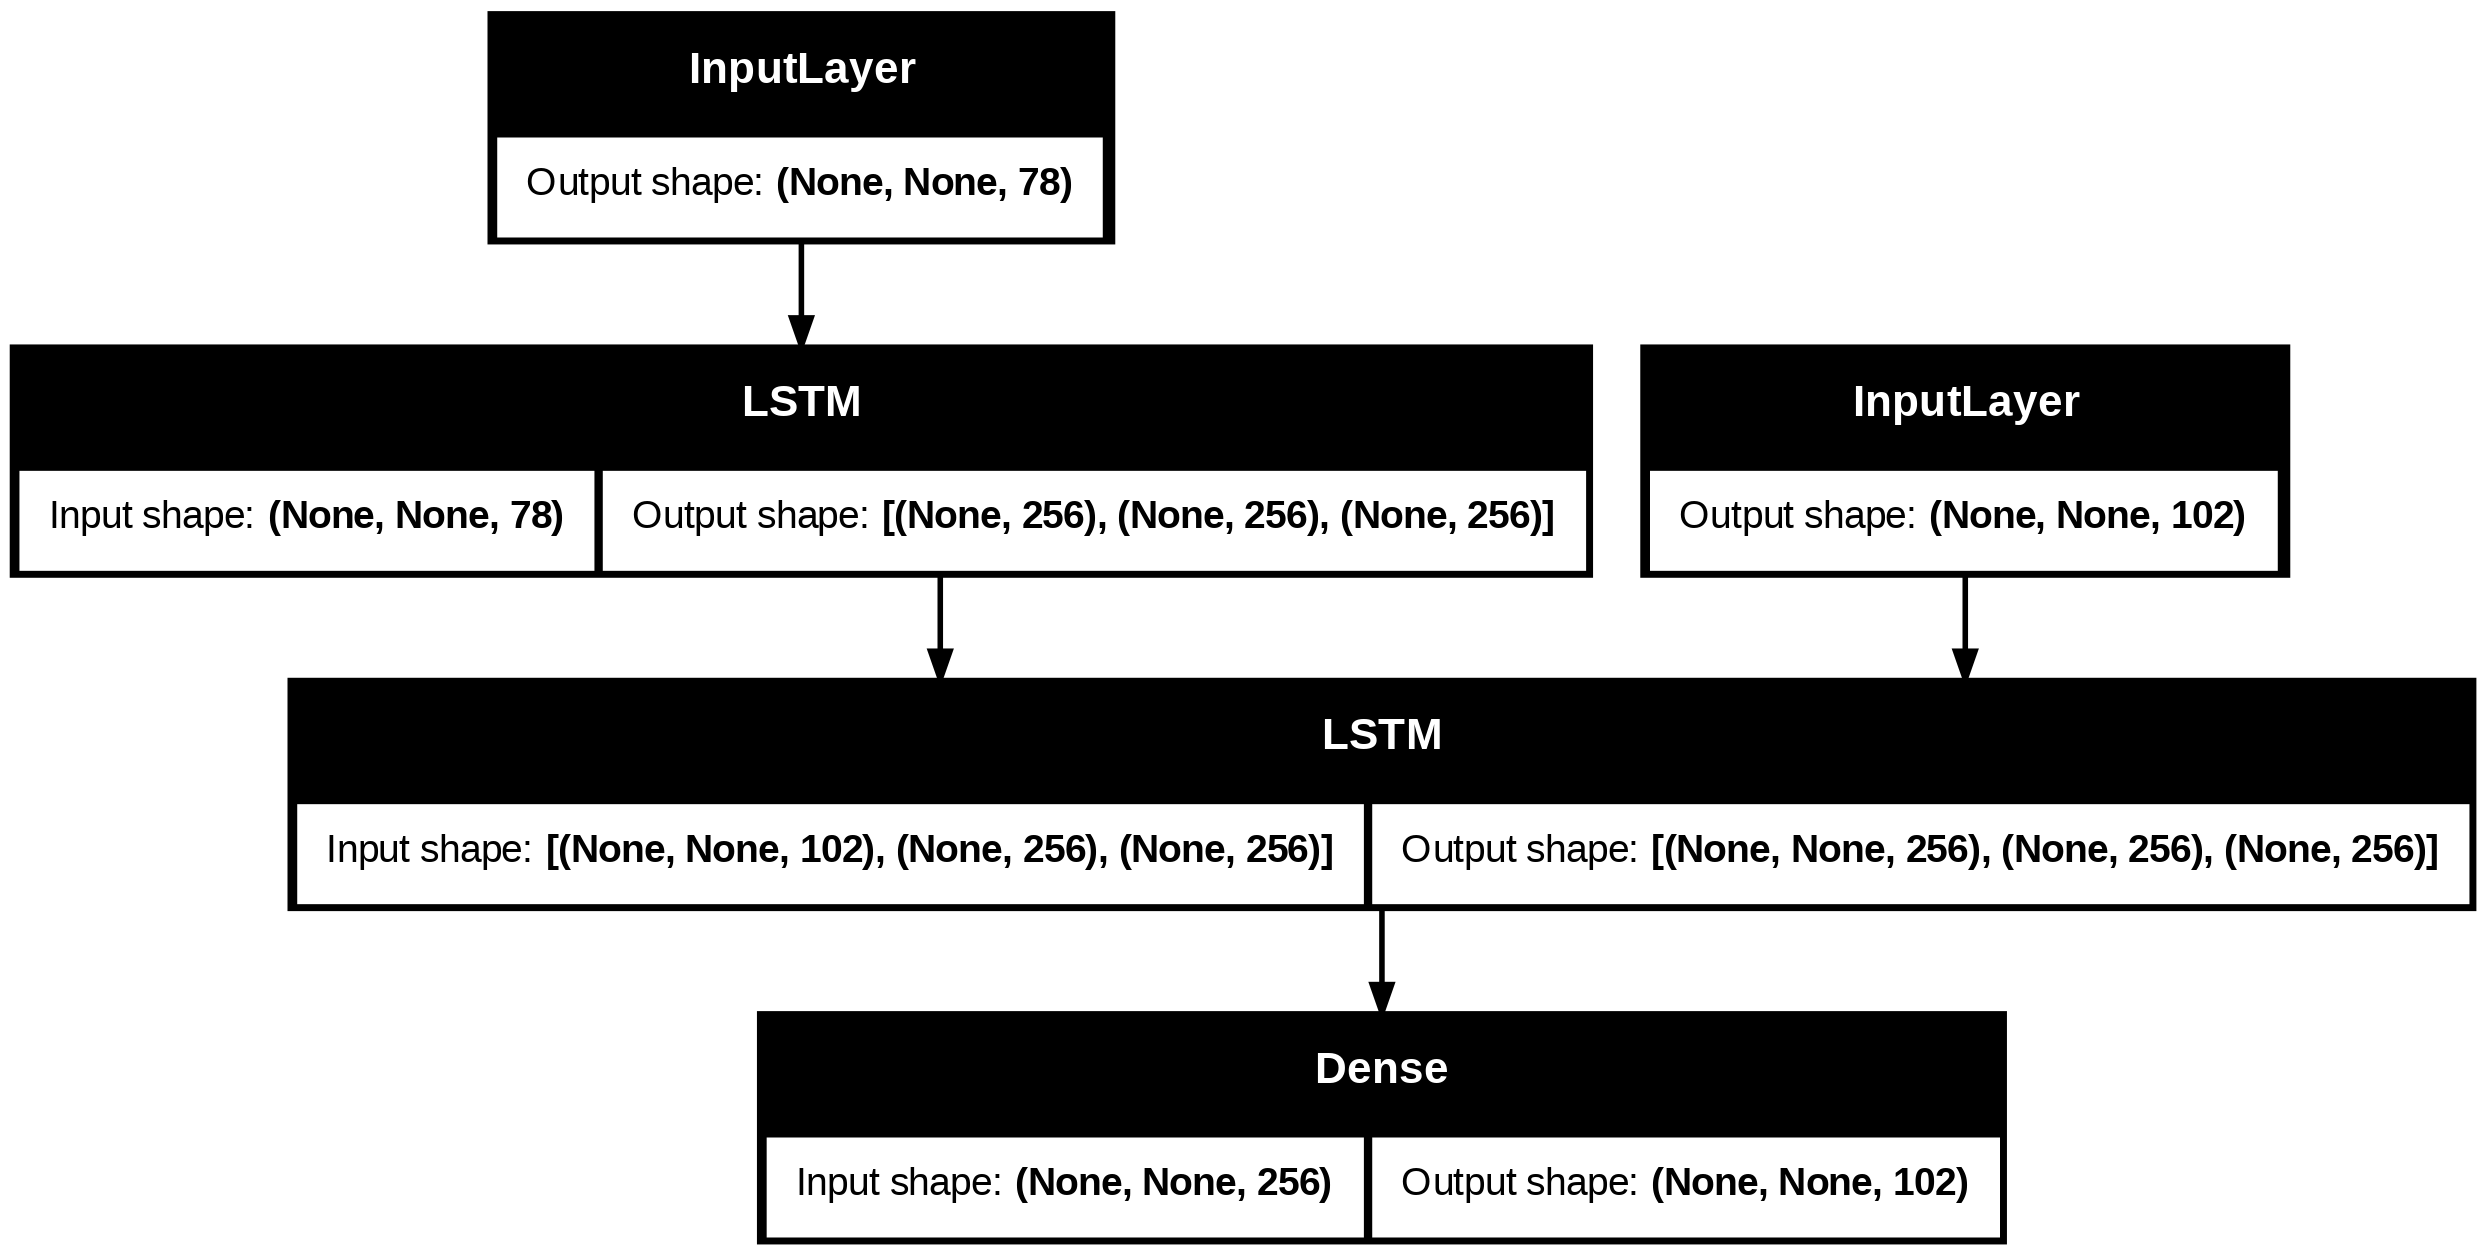

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64,
          epochs=200, validation_split=0.2)

Epoch 1/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 1.3921 - val_loss: 0.9211
Epoch 2/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.7404 - val_loss: 0.7974
Epoch 3/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.6399 - val_loss: 0.7330
Epoch 4/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.5806 - val_loss: 0.6763
Epoch 5/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.5345 - val_loss: 0.6274
Epoch 6/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.4970 - val_loss: 0.5980
Epoch 7/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.4697 - val_loss: 0.5745
Epoch 8/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.4492 - val_loss: 0.5547
Epoch 9/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.4321 - val_loss: 0.5394
Epoch 10/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.4181 - val_loss: 0.5262
Epoch 11/200
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.4045 - val_loss: 0.5118
Epoch 12/200
563/563 ━━━━━━

In [ ]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [ ]:
encoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, 78)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ [(None, 256), (None, 256),  │         343,040 │
│                                      │ (None, 256)]                │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 343,040 (1.31 MB)

 Trainable params: 343,040 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 이전 시점의 상태들을 저장하는 센서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용
# 뒤의 함수 decode_sequence()에 동작을 구현 예정
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,
                                                 initial_state=decoder_states_inputs)

# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않음
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs,
                      outputs=[decoder_outputs] + decoder_states)

In [ ]:
index_to_src = dict((i, char) for char, i in src_to_index.items())
index_to_tar = dict((i, char) for char, i in tar_to_index.items())

In [ ]:

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음, 예측한게 아님
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.0                # 소수점으로 나타내기 위해

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이전 시점의 상태 states_value를 현 시점의 초기 상태로 사용
      output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

      # 예측 결과를 문자로 변환
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = index_to_tar[sampled_token_index]

      # 현재 시점의 예측 문자를 예측 문장에 추가
      decoded_sentence += sampled_char

      # <eos>에 도달하거나 최대 길이를 넘으면 중단
      if (sampled_char == '\n' or len(decoded_sentence) > max_tar_len):
          stop_condition = True

      # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
      target_seq = np.zeros((1, 1, tar_vocab_size))
      target_seq[0, 0, sampled_token_index] = 1.

      # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
      states_value = [h, c]

    return decoded_sentence


In [ ]:
import random
temp = []
for i in range(10):
  temp.append(random.randint(0,45000))
temp

[12736, 33892, 31121, 43869, 42482, 42695, 105, 25492, 26931, 32263]

In [ ]:
for seq_index in temp: # 입력 문장의 인덱스
  input_seq = encoder_input[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print(35 * "-")
  print('입력 문장:', lines.src[seq_index])
  print('정답 문장:', lines.tar[seq_index][2:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
  print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━